In [14]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',header=None,sep='\s+')

In [15]:
df.columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [16]:
df.to_csv('housing.csv',index=False)

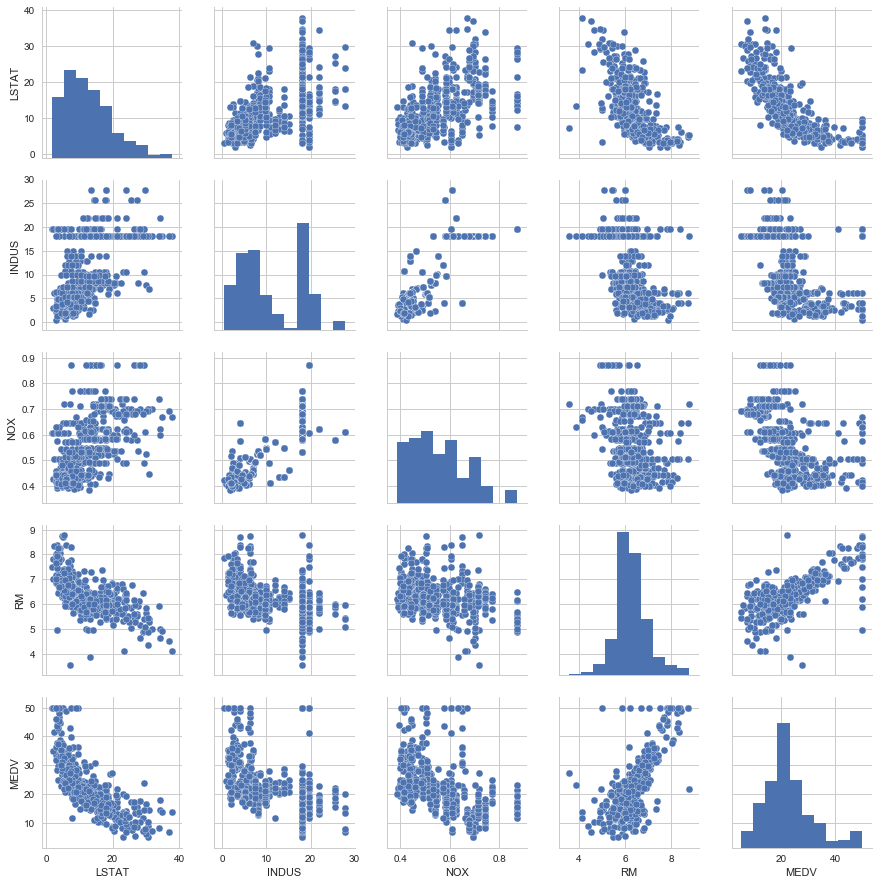

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',context='notebook')
cols=['LSTAT','INDUS','NOX','RM','MEDV']
sns.pairplot(df[cols],size=2.5)
plt.show()

相关系数矩阵
$$r=\frac {\sum_{i=1}^n [(x^{(i)}-\mu_x)(y^{(i)}-\mu_y)]} {\sqrt{\sum_{i=1}^n (x^{(i)}-\mu_x)^2} \sqrt{\sum_{i=1}^n (y^{(i)}-\mu_y)^2}} = \frac {\sigma_{xy}}{\sigma_x\sigma_y}$$

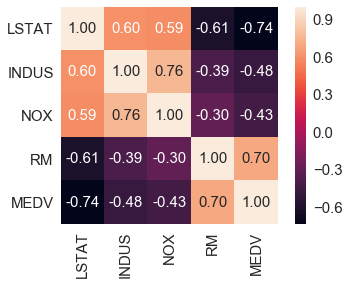

In [18]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,cbar=True,annot=True,
                square=True,fmt='.2f',
                annot_kws={'size':15},
                yticklabels=cols,xticklabels=cols)

In [19]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
X = df[['RM']].values
y = df['MEDV'].values
slr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
def lin_regplot(X,y,model):
    plt.scatter(X,y,c='blue')
    plt.plot(X,model.predict(X),color='red')
    return None

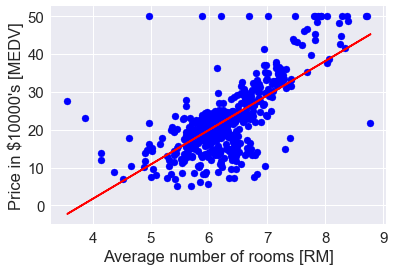

In [21]:
lin_regplot(X,y,slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $10000\'s [MEDV]')
plt.show()

### 使用RANSAC拟合高鲁棒性回归模型

In [22]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),max_trials=100,
                         min_samples=50,loss='absolute_loss',
                         residual_threshold=5.0,random_state=0)
ransac.fit(X,y)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

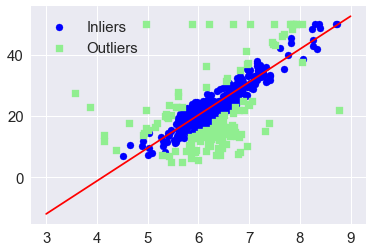

In [23]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],y[inlier_mask],c='blue',marker='o',label='Inliers')
plt.scatter(X[outlier_mask],y[outlier_mask],c='lightgreen',marker='s',label='Outliers')
plt.plot(line_X,line_y_ransac,color='red')
plt.legend(loc='upper left')
plt.show()

In [24]:
print(ransac.estimator_.coef_[0])

10.7345088085


### 线性回归模型性能评估

In [25]:
from sklearn.cross_validation import train_test_split
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
slr = LinearRegression()
slr.fit(X_train,y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

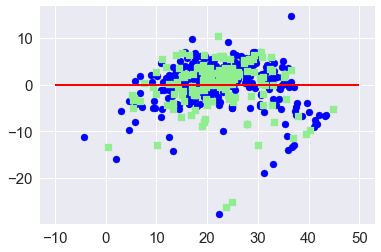

In [26]:
#残差图
plt.scatter(y_train_pred, y_train_pred-y_train,
           c='blue',marker='o',label='Training data')
plt.scatter(y_test_pred,y_test_pred-y_test,
           c='lightgreen',marker='s',label='Test data')
plt.hlines(y=0,xmin=-10,xmax=50,lw=2,color='red')

In [27]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' %(mean_squared_error(y_train,y_train_pred),mean_squared_error(y_test,y_test_pred)))

MSE train: 19.958, test: 27.196


In [28]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' %(r2_score(y_train,y_train_pred),r2_score(y_test,y_test_pred)))

R^2 train: 0.765, test: 0.673


### 多项式回归

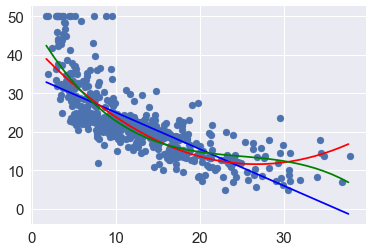

In [33]:
from sklearn.preprocessing import PolynomialFeatures
X = df[['LSTAT']].values
y = df['MEDV'].valuesi8
regr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
cubic= PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

#linear fit
X_fit = np.arange(X.min(),X.max(),1)[:,np.newaxis]
regr = regr.fit(X,y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y,regr.predict(X))

#quadratic fit
regr = regr.fit(X_quad,y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y,regr.predict(X_quad))

#cubic fit
regr = regr.fit(X_cubic,y)
y_cubic_fit =  regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y,regr.predict(X_cubic))

plt.scatter(X,y)
plt.plot(X_fit,y_lin_fit,color='blue')
plt.plot(X_fit,y_quad_fit,color='red')
plt.plot(X_fit,y_cubic_fit,color='green')